<a href="https://colab.research.google.com/github/Drime648/disaster-tweets/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-dae11e3e-1da1-1fb9-f253-6f5654ef2dba)


#Import

In [ ]:
import pandas as pd
import numpy as np

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

##Import Helper Functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-06-07 01:11:35--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-06-07 01:11:35 (95.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, unzip_data, plot_loss_curves, compare_historys

##Import a Text dataset

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

--2021-06-07 01:11:36--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.128, 142.250.101.128, 142.250.141.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.004s  

2021-06-07 01:11:36 (145 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [ ]:
unzip_data("/content/nlp_getting_started.zip")

In [ ]:
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

In [ ]:
train_df["text"][6845]

'in response to trauma Children of Addicts develop a defensive self - one that decreases vulnerability. (3'

In [ ]:
shuffled_train_df = train_df.sample(frac = 1, random_state=42)

In [ ]:
shuffled_train_df

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0
...,...,...,...,...,...
5226,7470,obliteration,Merica!,@Eganator2000 There aren't many Obliteration s...,0
5390,7691,panic,NaN,just had a panic attack bc I don't have enough...,0
860,1242,blood,NaN,Omron HEM-712C Automatic Blood Pressure Monito...,0
7603,10862,NaN,NaN,Officials say a quarantine is in place at an A...,1


In [ ]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [ ]:
import random

i = random.randint(0, len(train_df)-5)

for row in shuffled_train_df[["text", "target"]][i:i+5].itertuples():
  _, text, target = row
  print(f"{text}", "- Disaster" if target > 0 else "- Not a Disaster")
  print("")
  print("---\n")


Chevrolet : Avalanche LT 2011 lt used 5.3 l v 8 16 v automatic 4 wd pickup truck premium bÛ_ http://t.co/OBkY8Pc89H http://t.co/dXIRnTdSrd - Disaster

---

#TRAFFICALERT  Eastbound 210 Freeway at Citrus Ave in Azusa. Two motorcycles involved in accident with one fully engulfed in flames in lanes - Disaster

---

@burberryant bleeding on the brain don't know the cause - Not a Disaster

---

Red Faction: Armageddon  (Microsoft Xbox 360 2011) - Full read by eBay http://t.co/ypbVS1IJya http://t.co/9dFLv6ynqr - Not a Disaster

---

How ÛÏLittle BoyÛ Affected the People In Hiroshima ÛÒ Eyewitness Testimonials http://t.co/mUAnfWcRW9 - Disaster

---



##Split up the data

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_text, val_text, train_labels, val_labels = train_test_split(shuffled_train_df["text"].to_numpy(),
                                                                  shuffled_train_df["target"].to_numpy(),
                                                                  test_size = 0.1,
                                                                  random_state=42)

In [ ]:
len(train_text), len(val_text)

(6851, 762)

In [ ]:
len(train_labels), len(val_labels)

(6851, 762)

#Convert Text to Numbers

##Tokenization

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


In [ ]:
train_text[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [ ]:
a = round(sum([len(i.split()) for i in train_text]))

In [ ]:
avg_length = round(a / len(train_text))

In [ ]:
avg_length

15

In [ ]:
max_vocab_length = 10000
max_length = avg_length

In [ ]:
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_sequence_length = max_length,
                                    output_mode = "int")

In [ ]:
text_vectorizer.adapt(train_text)

In [ ]:
text_vectorizer

In [ ]:
sample_text = "jack my apartment blew up. Good thing my toilet is alive! #l"
text_vectorizer([sample_text])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[2078,   13, 4139,  555,   27,  136,  498,   13, 1749,    9, 1330,
        3696,    0,    0,    0]])>

In [ ]:
vocab = text_vectorizer.get_vocabulary()

In [ ]:
top5 = vocab[:5]

In [ ]:
top5

['', '[UNK]', 'the', 'a', 'in']

##Embedding

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

embedding_layer = layers.Embedding(input_dim=max_vocab_length,
                                   output_dim=128,
                                   input_length = max_length)


In [ ]:
vector = text_vectorizer([sample_text])

In [ ]:
embedded_vector = embedding_layer(vector)

In [ ]:
print(embedded_vector)
print("---\n")
print(vector)
print("---\n")
print(sample_text)

tf.Tensor(
[[[-0.018  0.016 -0.022 ...  0.023  0.033 -0.047]
  [ 0.008  0.035 -0.031 ... -0.013 -0.035 -0.018]
  [ 0.042 -0.041  0.028 ...  0.018  0.011  0.036]
  ...
  [-0.033  0.043 -0.048 ... -0.017  0.03  -0.005]
  [-0.033  0.043 -0.048 ... -0.017  0.03  -0.005]
  [-0.033  0.043 -0.048 ... -0.017  0.03  -0.005]]], shape=(1, 15, 128), dtype=float32)
---

tf.Tensor(
[[2078   13 4139  555   27  136  498   13 1749    9 1330 3696    0    0
     0]], shape=(1, 15), dtype=int64)
---

jack my apartment blew up. Good thing my toilet is alive! #l


#Make Model 0

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [ ]:
model_0 = Pipeline([
  ("tfidf", TfidfVectorizer()),
  ("clf", MultinomialNB()),
])

In [ ]:
model_0.fit(train_text, train_labels)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
base_score = model_0.score(val_text, val_labels)

79.26509186351706

In [ ]:
base_preds = model_0.predict(val_text)
base_preds

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,

#Evaluating function

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


In [ ]:
def eval(y_true, y_pred):
  #model accuracy
  accuracy = accuracy_score(y_true, y_pred)

  precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average = "weighted")

  results = {
      "accuracy": accuracy * 100,
      "precision": precision * 100,
      "recall": recall *100,
      "f1 score": f1 * 100
  }

  return results

In [ ]:
eval_0 = eval(val_labels, base_preds)

#Make Model 1

In [ ]:
from helper_functions import create_tensorboard_callback

save_dir = "model_logs"

In [ ]:
from tensorflow.keras import layers

In [ ]:
inputs = layers.Input(shape = (1,), dtype=tf.string)#1D strings
x = text_vectorizer(inputs) # turn string to number
x = embedding_layer(x) #turn numbers into embedding
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_1 = tf.keras.Model(inputs, outputs, name="Model_1")

In [ ]:
model_1.summary()

Model: "Model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_1.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
history_1 = model_1.fit(train_text, train_labels, epochs = 10,
            validation_data=(val_text, val_labels),
            callbacks=[create_tensorboard_callback(save_dir, "model_1")])

Saving TensorBoard log files to: model_logs/model_1/20210607-011144
Epoch 1/10
215/215 [==============================] - 7s 16ms/step - loss: 0.6143 - accuracy: 0.6796 - val_loss: 0.5372 - val_accuracy: 0.7638
Epoch 2/10
215/215 [==============================] - 3s 13ms/step - loss: 0.4421 - accuracy: 0.8175 - val_loss: 0.4697 - val_accuracy: 0.7835
Epoch 3/10
215/215 [==============================] - 3s 13ms/step - loss: 0.3466 - accuracy: 0.8622 - val_loss: 0.4614 - val_accuracy: 0.7953
Epoch 4/10
215/215 [==============================] - 3s 13ms/step - loss: 0.2844 - accuracy: 0.8911 - val_loss: 0.4632 - val_accuracy: 0.7835
Epoch 5/10
215/215 [==============================] - 3s 13ms/step - loss: 0.2370 - accuracy: 0.9133 - val_loss: 0.4830 - val_accuracy: 0.7874
Epoch 6/10
215/215 [==============================] - 3s 14ms/step - loss: 0.2009 - accuracy: 0.9288 - val_loss: 0.4991 - val_accuracy: 0.7874
Epoch 7/10
215/215 [==============================] - 3s 14ms/step - loss:

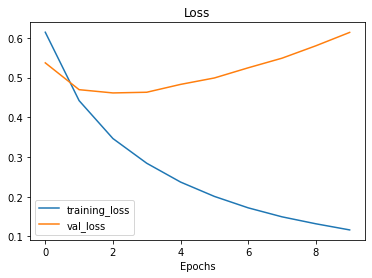

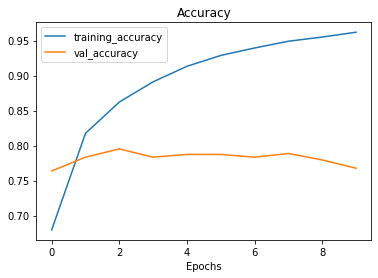

In [ ]:
plot_loss_curves(history_1)

In [ ]:
preds_1 = model_1.predict(val_text)
preds_1 = tf.squeeze(tf.round(preds_1))
preds_1[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
eval_1 = eval(val_labels, preds_1)

In [ ]:
eval_0, eval_1

({'accuracy': 79.26509186351706,
  'f1 score': 78.6218975804955,
  'precision': 81.11390004213173,
  'recall': 79.26509186351706},
 {'accuracy': 76.77165354330708,
  'f1 score': 76.60466459325423,
  'precision': 76.8489862704666,
  'recall': 76.77165354330708})

Baseline is better

#Visualizing Embeddings

https://www.tensorflow.org/text/guide/word_embeddings

In [ ]:
model_1.summary()

Model: "Model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [ ]:
len(vocab), vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [ ]:
embed_weights = model_1.get_layer("embedding").get_weights()[0]

In [ ]:
embed_weights.shape

(10000, 128)

In [ ]:
embed_weights == model_1.get_layer("embedding").get_weights()

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]])

In [ ]:
weights = model_1.get_layer('embedding').get_weights()[0]
vocab = text_vectorizer.get_vocabulary()


In [ ]:
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()


In [ ]:
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#RNN Models

##Make Model 2(LSTM)

LSTM - Long Short Term Memory

In [ ]:
inputs = layers.Input(shape = (1,), dtype=tf.string)#1D strings


x = text_vectorizer(inputs) # turn string to number
x = embedding_layer(x) #turn numbers into embedding

x = layers.LSTM(units = 64, return_sequences=True)(x) # inputs = 3 dimensions, output = 3 dimensions. Return sequences must be true when stackng RNN
x = layers.LSTM(64)(x) # inputs = 3 dimensions, output = 2 dimensions

x = layers.Dense(64, activation = "relu")(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model_2 = tf.keras.Model(inputs, outputs, name="Model_2")

In [ ]:
model_2.summary()

Model: "Model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 15, 64)            49408     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65  

In [ ]:
model_2.compile(loss = "binary_crossentropy",
                optimizer = "Adam",
                metrics = ["accuracy"])

In [ ]:
history_2 = model_2.fit(train_text, train_labels, epochs = 7,
            validation_data=(val_text, val_labels),
            callbacks=[create_tensorboard_callback(save_dir, "model_2")])

Saving TensorBoard log files to: model_logs/model_2/20210607-011220
Epoch 1/7
215/215 [==============================] - 12s 26ms/step - loss: 0.1433 - accuracy: 0.9556 - val_loss: 0.6960 - val_accuracy: 0.7743
Epoch 2/7
215/215 [==============================] - 4s 19ms/step - loss: 0.0875 - accuracy: 0.9656 - val_loss: 0.7592 - val_accuracy: 0.7756
Epoch 3/7
215/215 [==============================] - 4s 18ms/step - loss: 0.0808 - accuracy: 0.9683 - val_loss: 0.8994 - val_accuracy: 0.7690
Epoch 4/7
215/215 [==============================] - 4s 19ms/step - loss: 0.0659 - accuracy: 0.9745 - val_loss: 1.1428 - val_accuracy: 0.7756
Epoch 5/7
215/215 [==============================] - 4s 18ms/step - loss: 0.0579 - accuracy: 0.9765 - val_loss: 1.0788 - val_accuracy: 0.7717
Epoch 6/7
215/215 [==============================] - 4s 18ms/step - loss: 0.0510 - accuracy: 0.9769 - val_loss: 1.4218 - val_accuracy: 0.7730
Epoch 7/7
215/215 [==============================] - 4s 18ms/step - loss: 0.048

In [ ]:
model_2.evaluate(val_text, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 1.4381 - accuracy: 0.7743


[1.4381229877471924, 0.7742782235145569]

In [ ]:
preds_2 = model_2.predict(val_text)
preds_2 = tf.squeeze(tf.round(preds_2))
preds_2

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0

In [ ]:
eval_2 = eval(val_labels, preds_2)

In [ ]:
eval_0, eval_1, eval_2

({'accuracy': 79.26509186351706,
  'f1 score': 78.6218975804955,
  'precision': 81.11390004213173,
  'recall': 79.26509186351706},
 {'accuracy': 76.77165354330708,
  'f1 score': 76.60466459325423,
  'precision': 76.8489862704666,
  'recall': 76.77165354330708},
 {'accuracy': 77.42782152230971,
  'f1 score': 77.18342766442733,
  'precision': 77.68468681584156,
  'recall': 77.42782152230971})

##Make Model 3(GRU)

GRU - Gated Recurrent Unit

In [ ]:
inputs = layers.Input(shape = (1,), dtype=tf.string)#1D strings


x = text_vectorizer(inputs) # turn string to number
x = embedding_layer(x) #turn numbers into embedding

x = layers.GRU(256, return_sequences=True)(x)
x = layers.GRU(128, return_sequences = True)(x)
x = layers.LSTM(64, return_sequences = True)(x)
x = layers.GlobalAveragePooling1D()(x)

x = layers.Dense(64, activation = "relu")(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model_3 = tf.keras.Model(inputs, outputs, name="Model_3")

In [ ]:
model_3.summary()

Model: "Model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 15, 256)           296448    
_________________________________________________________________
gru_1 (GRU)                  (None, 15, 128)           148224    
_________________________________________________________________
lstm_2 (LSTM)                (None, 15, 64)            49408     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0   

In [ ]:
model_3.compile(loss = "binary_crossentropy",
                optimizer = "Adam",
                metrics = ["accuracy"])

In [ ]:
history_3 = model_3.fit(train_text, train_labels, epochs = 5,
            validation_data=(val_text, val_labels),
            callbacks=[create_tensorboard_callback(save_dir, "model_3")])

Saving TensorBoard log files to: model_logs/model_3/20210607-011257
Epoch 1/5
215/215 [==============================] - 9s 27ms/step - loss: 0.1190 - accuracy: 0.9564 - val_loss: 0.9186 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0642 - accuracy: 0.9727 - val_loss: 0.9803 - val_accuracy: 0.7598
Epoch 3/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0540 - accuracy: 0.9755 - val_loss: 1.3870 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0521 - accuracy: 0.9762 - val_loss: 1.6958 - val_accuracy: 0.7585
Epoch 5/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0523 - accuracy: 0.9775 - val_loss: 1.5046 - val_accuracy: 0.7690


##Make Model 4(Bi-directional RNN)

Goes Left to Right and Right to Left

In [ ]:
inputs = layers.Input(shape = (1,), dtype=tf.string)#1D strings


x = text_vectorizer(inputs) # turn string to number
x = embedding_layer(x) #turn numbers into embedding

x = layers.Bidirectional(layers.LSTM(64, return_sequences = True))(x)
x = layers.Bidirectional(layers.GRU(64))(x)

# x = layers.Dense(64, activation = "relu")(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model_4 = tf.keras.Model(inputs, outputs, name="Model_4")

In [ ]:
model_4.summary()

Model: "Model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 15, 128)           98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               74496     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 1,453,441
Trainable params: 1,453,441
Non-trainable params: 0
_________________________________________________

In [ ]:
model_4.compile(loss = "binary_crossentropy",
                optimizer = "Adam",
                metrics = ["accuracy"])

In [ ]:
history_4 = model_4.fit(train_text, train_labels, epochs = 5,
            validation_data=(val_text, val_labels),
            callbacks=[create_tensorboard_callback(save_dir, "model_4")])

Saving TensorBoard log files to: model_logs/model_4/20210607-011343
Epoch 1/5
215/215 [==============================] - 11s 31ms/step - loss: 0.0905 - accuracy: 0.9715 - val_loss: 1.0921 - val_accuracy: 0.7664
Epoch 2/5
215/215 [==============================] - 5s 22ms/step - loss: 0.0470 - accuracy: 0.9775 - val_loss: 1.3496 - val_accuracy: 0.7664
Epoch 3/5
215/215 [==============================] - 5s 21ms/step - loss: 0.0420 - accuracy: 0.9791 - val_loss: 1.5474 - val_accuracy: 0.7559
Epoch 4/5
215/215 [==============================] - 4s 21ms/step - loss: 0.0401 - accuracy: 0.9790 - val_loss: 1.3320 - val_accuracy: 0.7664
Epoch 5/5
215/215 [==============================] - 4s 21ms/step - loss: 0.0414 - accuracy: 0.9800 - val_loss: 1.1430 - val_accuracy: 0.7559


#Making Model 5 (Conv1D)

In [ ]:
embedding_test = embedding_layer(text_vectorizer(["This is a sample sentence"]))
conv1d = layers.Conv1D(32, 5, activation="relu", padding="valid")

conv1d_output = conv1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv1d_output)

In [ ]:
max_pool_output

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[0.087, 0.034, 0.031, 0.04 , 0.052, 0.053, 0.018, 0.05 , 0.025,
        0.085, 0.006, 0.03 , 0.027, 0.027, 0.025, 0.079, 0.06 , 0.036,
        0.029, 0.017, 0.038, 0.052, 0.019, 0.014, 0.066, 0.043, 0.04 ,
        0.055, 0.021, 0.06 , 0.053, 0.04 ]], dtype=float32)>

In [ ]:
inputs = layers.Input(shape = (1,), dtype=tf.string)#1D strings


x = text_vectorizer(inputs) # turn string to number
x = embedding_layer(x) #turn numbers into embedding

x = layers.Conv1D(64, 5, activation = "relu")(x)
x = layers.Conv1D(64, 5, activation = "relu")(x)
x = layers.GlobalMaxPooling1D()(x)


# x = layers.Dense(64, activation = "relu")(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model_5 = tf.keras.Model(inputs, outputs, name="Model_5")

In [ ]:
model_5.compile(loss = "binary_crossentropy",
                optimizer = "Adam",
                metrics = ["accuracy"])

In [ ]:
history_5 = model_5.fit(train_text, train_labels, epochs = 5,
            validation_data=(val_text, val_labels),
            callbacks=[create_tensorboard_callback(save_dir, "model_5")])

Saving TensorBoard log files to: model_logs/model_5/20210607-014558
Epoch 1/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0843 - accuracy: 0.9689 - val_loss: 1.2046 - val_accuracy: 0.7638
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0485 - accuracy: 0.9803 - val_loss: 1.2307 - val_accuracy: 0.7546
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0454 - accuracy: 0.9803 - val_loss: 1.4302 - val_accuracy: 0.7585
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0424 - accuracy: 0.9815 - val_loss: 1.3542 - val_accuracy: 0.7559
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0377 - accuracy: 0.9831 - val_loss: 1.5603 - val_accuracy: 0.7454


#Using Transfer Learning

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embeddings = embed([
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding",
    "cat"])

print(embeddings)


tf.Tensor(
[[-0.03133018 -0.06338634 -0.01607501 ... -0.0324278  -0.04575741
   0.05370455]
 [ 0.05080862 -0.01652431  0.01573782 ...  0.00976659  0.0317012
   0.0178812 ]
 [-0.06458329 -0.00307437  0.02157442 ... -0.0302397   0.04162949
   0.00189026]], shape=(3, 512), dtype=float32)


In [ ]:
from tensorflow.keras import layers


In [ ]:
sentence_encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                  input_shape = [],
                                  dtype = tf.string,
                                  name = "sentence_encoding_layer")

In [ ]:
model_6 = tf.keras.Sequential([
  sentence_encoder,
  layers.Dense(64, activation = "relu"),
  layers.Dense(1, activation="sigmoid")
], name = "model_6")

In [ ]:
model_6.compile(loss = "binary_crossentropy",
                optimizer = "Adam",
                metrics = ["accuracy"])

In [ ]:
model_6.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sentence_encoding_layer (Ker (None, 512)               256797824 
_________________________________________________________________
dense_15 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
history_6 = model_6.fit(train_text, train_labels, epochs = 20,
            validation_data=(val_text, val_labels),
            callbacks=[create_tensorboard_callback(save_dir, "model_6")])

Saving TensorBoard log files to: model_logs/model_6/20210607-021258
Epoch 1/20
215/215 [==============================] - 4s 15ms/step - loss: 0.5087 - accuracy: 0.7771 - val_loss: 0.4424 - val_accuracy: 0.7992
Epoch 2/20
215/215 [==============================] - 2s 10ms/step - loss: 0.4151 - accuracy: 0.8154 - val_loss: 0.4360 - val_accuracy: 0.8071
Epoch 3/20
215/215 [==============================] - 2s 10ms/step - loss: 0.4007 - accuracy: 0.8244 - val_loss: 0.4324 - val_accuracy: 0.8097
Epoch 4/20
215/215 [==============================] - 2s 10ms/step - loss: 0.3919 - accuracy: 0.8259 - val_loss: 0.4256 - val_accuracy: 0.8150
Epoch 5/20
215/215 [==============================] - 2s 10ms/step - loss: 0.3851 - accuracy: 0.8326 - val_loss: 0.4282 - val_accuracy: 0.8202
Epoch 6/20
215/215 [==============================] - 2s 10ms/step - loss: 0.3777 - accuracy: 0.8351 - val_loss: 0.4333 - val_accuracy: 0.8045
Epoch 7/20
215/215 [==============================] - 2s 10ms/step - loss:

In [ ]:
#accuracy = 82.81%